# Dynamic Estimation Loss Control in Variational Quantum Sensing via Online Conformal Inference


This notebook explores an online control framework for variational quantum sensing (VQS) that (a) dynamically updates the variational parameters (b) while providing deterministic error bars on the estimates. By leveraging online conformal inference techniques, the approach produces sequential estimation sets with a guaranteed long-term risk level.

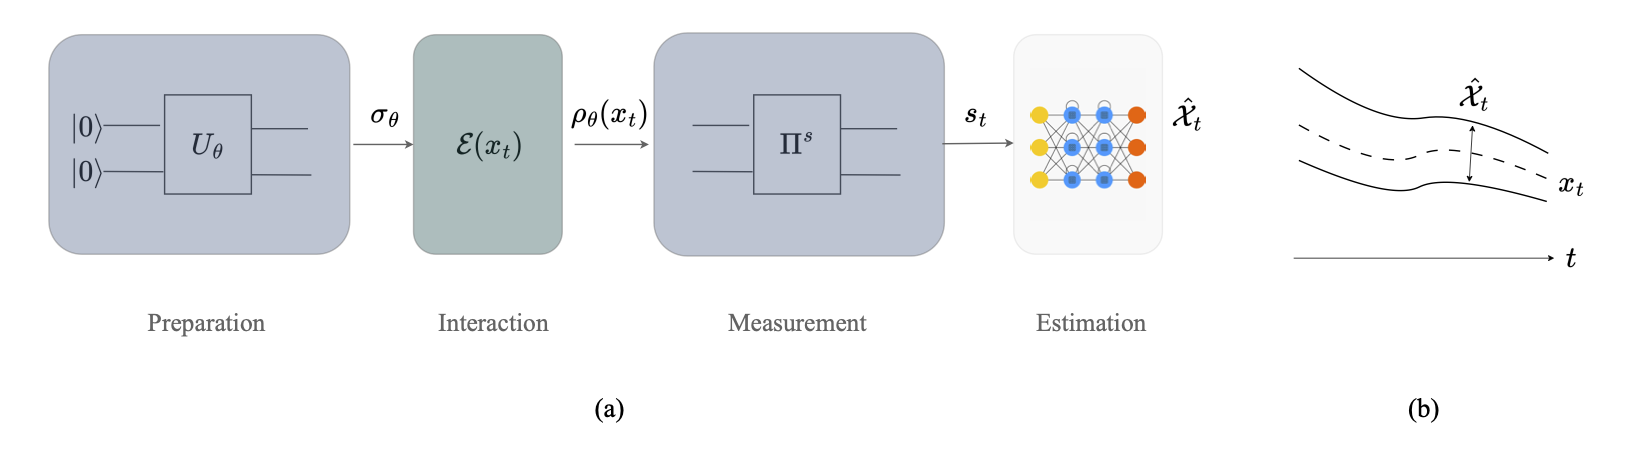

**Key Components:**

- **Variational Quantum Circuit (VQC):** Implemented using PennyLane, this circuit prepares quantum probes based on trainable parameters. The circuit includes Hadamard gates for initial superposition, parameterized rotation gates (RZ, RX), and entanglement gates (MultiRZ).
- **LSTM Model:** A standard PyTorch LSTM network that processes the measurement outcomes and outputs probabilities for different classes (representing possible values of the parameter of interest).
- **Conformal Inference (ARC):** An algorithm that utilizes the LSTM's output probabilities to construct prediction sets. The `ARC` function calculates the size of the prediction set and the predicted values based on a confidence level.
- **Training Loop:** An iterative process that trains both the LSTM model and the parameters of the VQC to minimize the loss function that considers both the LSTM's prediction loss and the size of the prediction set.

In [ ]:

!pip install pennylane
import pennylane as qml




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 30.5 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:

import torch
import os
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple

!pip install sympy==1.12

import itertools
import random
IterRMSE = namedtuple("Stats_BIAS",["iter_BIAS"])
IterBCE = namedtuple("Stats_Epoch",["iter_Epoch"])

import pickle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 37.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cud

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #change this to your location for storing the results

Mounted at /content/drive


### Variational Quantum Circuit (VQC) Definition

This section defines the Variational Quantum Circuit (VQC) using PennyLane. The circuit acts as a data encoder and feature extractor.

- **`dev`:** Specifies the quantum device for simulation (`default.qubit`).
- **`@qml.qnode`:** Decorator that turns the Python function into a QNode, enabling automatic differentiation.
- **`circuit(params, n_qubits, n_layers, phi)`:** The main function defining the VQC.
    - **`params`:** Trainable parameters of the circuit.
    - **`n_qubits`:** Number of qubits in the circuit.
    - **`n_layers`:** Number of layers of parameterized gates.
    - **`phi`:** Sensing parameter of interest.
- **Circuit Layers:**
    - Initial Hadamard gates for superposition.
    - Repeated layers of parameterized single-qubit rotations (RZ, RX).
    - Entangling layers using MultiRZ gates.
- **Return Value:** Returns quantum measurement samples.

In [ ]:
n_qubits = 4

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def circuit(params, n_qubits, n_layers,phi):

    for i in range(0, n_qubits):
        qml.Hadamard(wires=i)

    for t in range(0,n_layers):
        for i in range(0, n_qubits):
            qml.RZ(params[2*t + t], wires=i)
            qml.RX(params[2*t + t + 1], wires=i)


        for i in range(n_qubits-1):
        #    qml.CNOT(wires=[i, i+1])
            qml.MultiRZ(params[2*t + t + 2], wires=[i, i+1])

    for i in range(0, n_qubits):
        qml.RZ(phi, i)


    return [qml.sample()]

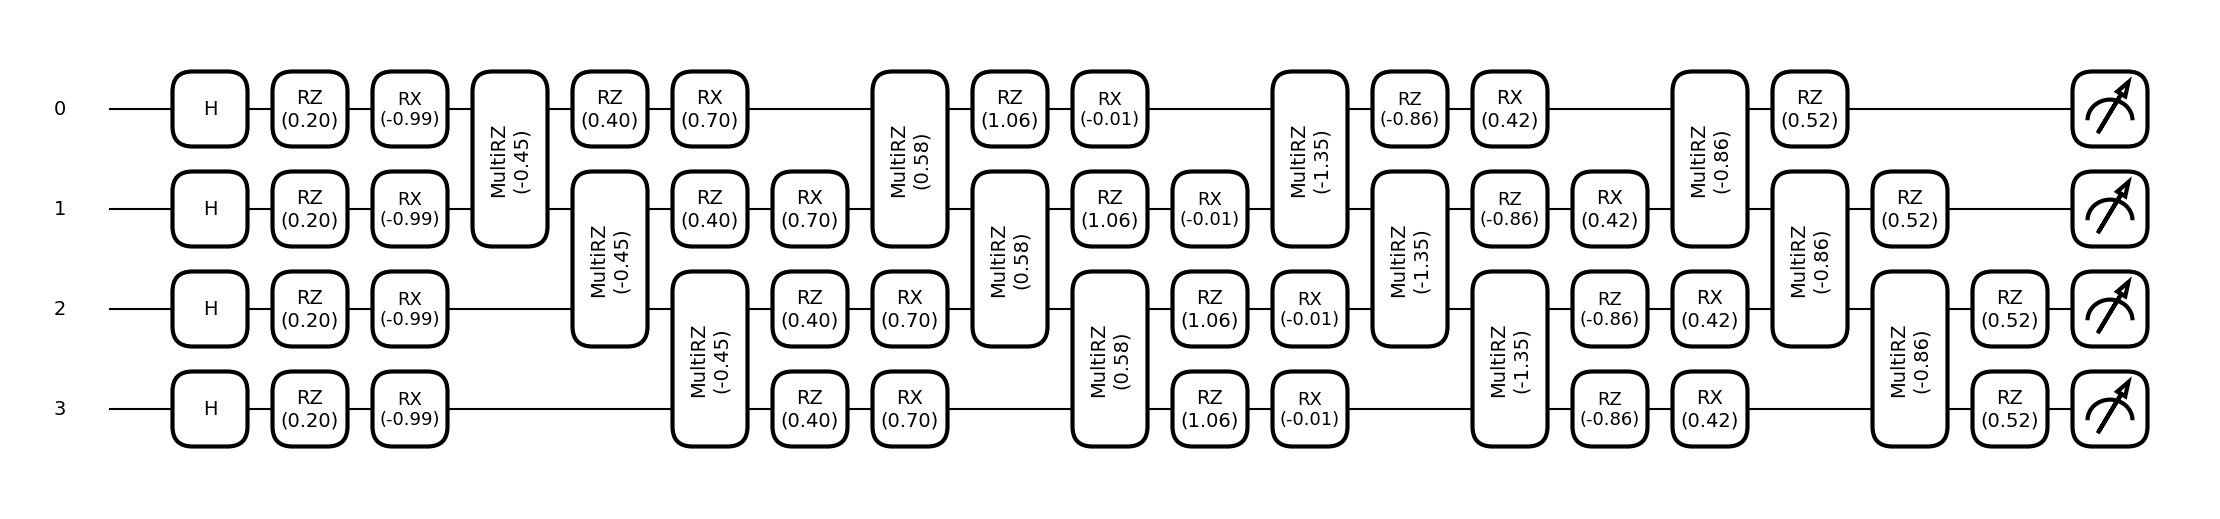

In [ ]:
n_layers = 4
#n_params = n_qubits*n_layers*2
n_params = 3*n_layers
params = np.random.normal(0,1,n_params)
phi = np.pi/6

fig, ax = qml.draw_mpl(circuit, decimals=2)(params, n_qubits, n_layers, phi)
plt.show()

### Classical LSTM Model

This section defines the classical Long Short-Term Memory (LSTM) model using PyTorch. This model takes the quantum measurement samples as input and outputs predictions.

- **`LSTMModel(nn.Module)`:** Defines the LSTM class inheriting from `torch.nn.Module`.
    - **`__init__(self, input_size, hidden_size, output_size)`:** Initializes the LSTM layers.
        - **`lstm`:** The PyTorch LSTM layer.
        - **`fc1`, `fc2`:** Fully connected layers for processing the LSTM output.
    - **`forward(self, x)`:** Defines the forward pass of the model.
        - Processes the input `x` through the LSTM and the fully connected layers.
        - The output of the LSTM is then passed through the linear layers to produce the final output.

### Adaptive Risk Control (ARC) Function

This function implements the Adaptive Risk Control Algorithm. It takes the output probabilities from the LSTM and constructs a prediction set.

- **`ARC(models, data, target_arc, lam, eta_t, err_t)`:**
    - **`models`:** A list of trained LSTM models (for ensemble prediction).
    - **`data`:** The input data (quantum measurement).
    - **`target_arc`:** The true label for calculating coverage.
    - **`lam`:** A threshold parameter for constructing the prediction set.
    - **`eta_t`:** Learning rate for updating `lam`.
    - **`err_t`:** Target error rate for the prediction set.
- **Process:**
    - Computes ensemble probabilities from the LSTM models.
    - Uses the threshold `lam` to select classes for the prediction set based on their probabilities.
    - Calculates a 'soft set' value, in order to optimise the set size with gradient descent.
- **Return Values:** Returns the size of the prediction set, the predicted values in the set, and the soft set value.

Trial 0
Epoch: 0 NLL loss: 0.013645541854202747 Coverage 0.64 Set loss 0.11309733552923255 Set size tensor(4.5000, grad_fn=<DivBackward0>)
Epoch: 1 NLL loss: -0.1642002910375595 Coverage 0.37 Set loss 1.4325662500369458 Set size tensor(3.7977, grad_fn=<DivBackward0>)
Epoch: 2 NLL loss: -0.2344464212656021 Coverage 0.58 Set loss 0.0 Set size tensor(6.0490, grad_fn=<DivBackward0>)
Epoch: 3 NLL loss: -0.46325188875198364 Coverage 0.6799999999999999 Set loss 0.006283185307179587 Set size tensor(5.5836, grad_fn=<DivBackward0>)
Epoch: 4 NLL loss: -0.8252955675125122 Coverage 0.732 Set loss 0.01884955592153876 Set size tensor(5.1505, grad_fn=<DivBackward0>)
Epoch: 5 NLL loss: -1.3859214782714844 Coverage 0.7599999999999999 Set loss 0.031415926535897934 Set size tensor(4.7470, grad_fn=<DivBackward0>)
Epoch: 6 NLL loss: -1.1651546955108643 Coverage 0.7028571428571428 Set loss 0.8042477193189871 Set size tensor(4.3723, grad_fn=<DivBackward0>)
Epoch: 7 NLL loss: -1.2219417095184326 Coverage 0.732

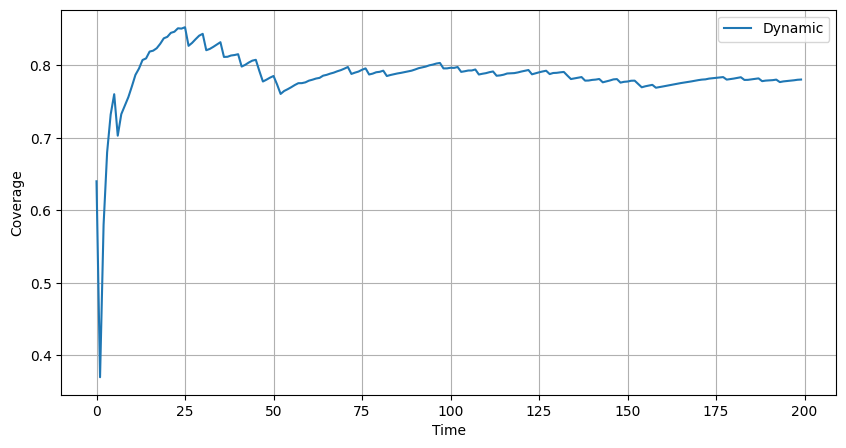

Trial 1
Epoch: 0 NLL loss: 0.0154349897056818 Coverage 0.46 Set loss 0.19477874452256716 Set size tensor(4.5000, grad_fn=<DivBackward0>)
Epoch: 1 NLL loss: 0.003072993829846382 Coverage 0.28 Set loss 1.2377875055143788 Set size tensor(3.7976, grad_fn=<DivBackward0>)
Epoch: 2 NLL loss: -0.07640685141086578 Coverage 0.52 Set loss 0.0 Set size tensor(6.0495, grad_fn=<DivBackward0>)
Epoch: 3 NLL loss: -0.22343546152114868 Coverage 0.64 Set loss 0.0 Set size tensor(5.5845, grad_fn=<DivBackward0>)
Epoch: 4 NLL loss: -0.7549471259117126 Coverage 0.712 Set loss 0.0 Set size tensor(5.1511, grad_fn=<DivBackward0>)
Epoch: 5 NLL loss: -0.4101095497608185 Coverage 0.7433333333333333 Set loss 0.031415926535897934 Set size tensor(4.7466, grad_fn=<DivBackward0>)
Epoch: 6 NLL loss: -0.9692510962486267 Coverage 0.6457142857142857 Set loss 1.3571680263507906 Set size tensor(4.3695, grad_fn=<DivBackward0>)
Epoch: 7 NLL loss: -1.67117178440094 Coverage 0.69 Set loss 0.0 Set size tensor(5.7531, grad_fn=<Div

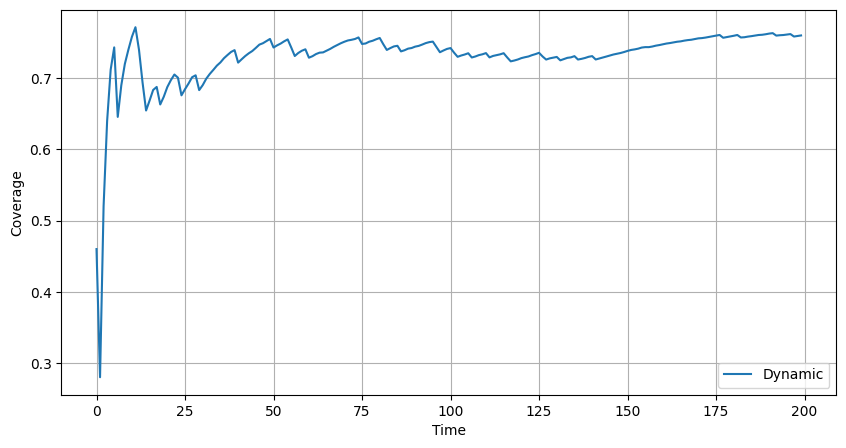

Trial 2
Epoch: 0 NLL loss: -0.09430823475122452 Coverage 0.68 Set loss 0.10053096491487339 Set size tensor(4.5000, grad_fn=<DivBackward0>)
Epoch: 1 NLL loss: -0.34107691049575806 Coverage 0.37 Set loss 1.4953981031087422 Set size tensor(3.7983, grad_fn=<DivBackward0>)
Epoch: 2 NLL loss: -0.6555097103118896 Coverage 0.58 Set loss 0.0 Set size tensor(6.0471, grad_fn=<DivBackward0>)
Epoch: 3 NLL loss: -1.2661763429641724 Coverage 0.675 Set loss 0.012566370614359173 Set size tensor(5.5815, grad_fn=<DivBackward0>)
Epoch: 4 NLL loss: -1.4970519542694092 Coverage 0.704 Set loss 0.05654866776461628 Set size tensor(5.1497, grad_fn=<DivBackward0>)
Epoch: 5 NLL loss: -2.180243968963623 Coverage 0.7433333333333333 Set loss 0.01884955592153876 Set size tensor(6.6130, grad_fn=<DivBackward0>)
Epoch: 6 NLL loss: -1.9428237676620483 Coverage 0.7657142857142858 Set loss 0.031415926535897934 Set size tensor(6.2944, grad_fn=<DivBackward0>)
Epoch: 7 NLL loss: -3.5174431800842285 Coverage 0.78 Set loss 0.03

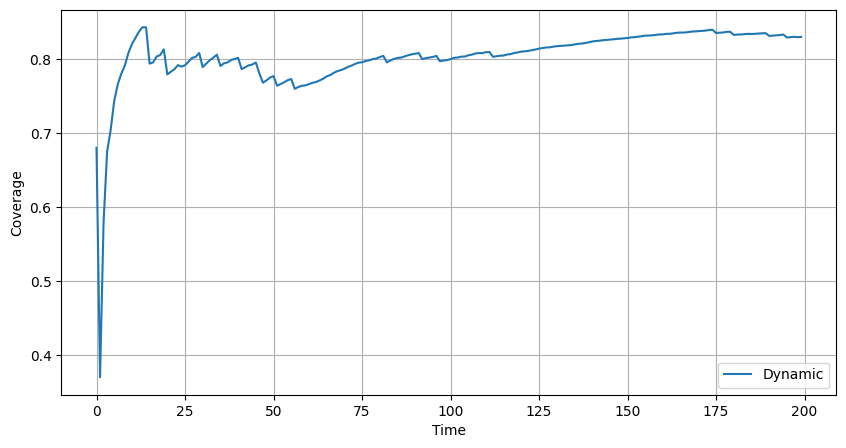

Trial 3
Epoch: 0 NLL loss: -0.030463367700576782 Coverage 0.74 Set loss 0.09424777960769379 Set size tensor(4.5000, grad_fn=<DivBackward0>)
Epoch: 1 NLL loss: -0.2941875159740448 Coverage 0.42 Set loss 1.5707963267948972 Set size tensor(3.7979, grad_fn=<DivBackward0>)
Epoch: 2 NLL loss: -0.6277730464935303 Coverage 0.6133333333333333 Set loss 0.0 Set size tensor(6.0480, grad_fn=<DivBackward0>)
Epoch: 3 NLL loss: -0.7824826836585999 Coverage 0.71 Set loss 0.0 Set size tensor(5.5821, grad_fn=<DivBackward0>)
Epoch: 4 NLL loss: -1.5288293361663818 Coverage 0.752 Set loss 0.025132741228718346 Set size tensor(5.1496, grad_fn=<DivBackward0>)
Epoch: 5 NLL loss: -2.0354175567626953 Coverage 0.7766666666666667 Set loss 0.031415926535897934 Set size tensor(4.7517, grad_fn=<DivBackward0>)
Epoch: 6 NLL loss: -1.2286549806594849 Coverage 0.7828571428571429 Set loss 0.10681415022205297 Set size tensor(4.3824, grad_fn=<DivBackward0>)
Epoch: 7 NLL loss: -2.186379909515381 Coverage 0.7000000000000001 Se

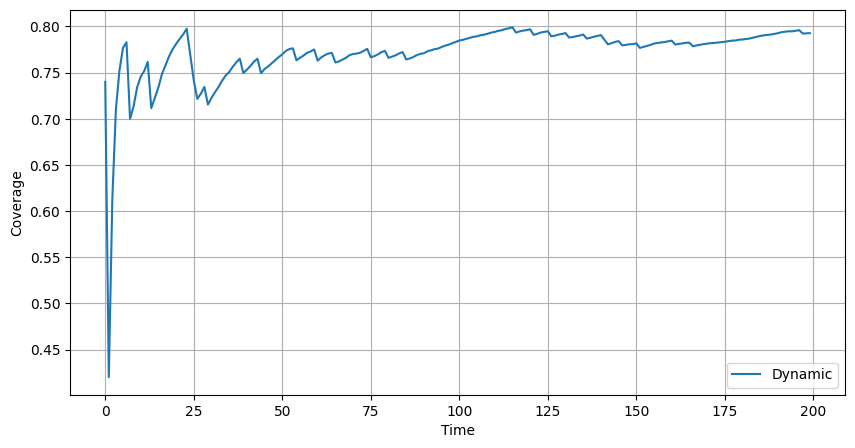

Trial 4
Epoch: 0 NLL loss: 0.0406491681933403 Coverage 0.5 Set loss 0.20106192982974677 Set size tensor(4.5000, grad_fn=<DivBackward0>)
Epoch: 1 NLL loss: 0.022933632135391235 Coverage 0.29 Set loss 1.2503538761287376 Set size tensor(3.7976, grad_fn=<DivBackward0>)
Epoch: 2 NLL loss: -0.015907928347587585 Coverage 0.5266666666666667 Set loss 0.0 Set size tensor(6.0496, grad_fn=<DivBackward0>)
Epoch: 3 NLL loss: -0.04839376360177994 Coverage 0.645 Set loss 0.0 Set size tensor(5.5847, grad_fn=<DivBackward0>)
Epoch: 4 NLL loss: -0.07625079154968262 Coverage 0.716 Set loss 0.0 Set size tensor(5.1513, grad_fn=<DivBackward0>)
Epoch: 5 NLL loss: -0.1403704285621643 Coverage 0.7600000000000001 Set loss 0.006283185307179587 Set size tensor(4.7466, grad_fn=<DivBackward0>)
Epoch: 6 NLL loss: -0.08485947549343109 Coverage 0.66 Set loss 1.5959290680236151 Set size tensor(4.3689, grad_fn=<DivBackward0>)
Epoch: 7 NLL loss: -0.3991835117340088 Coverage 0.7025 Set loss 0.0 Set size tensor(5.7554, grad_

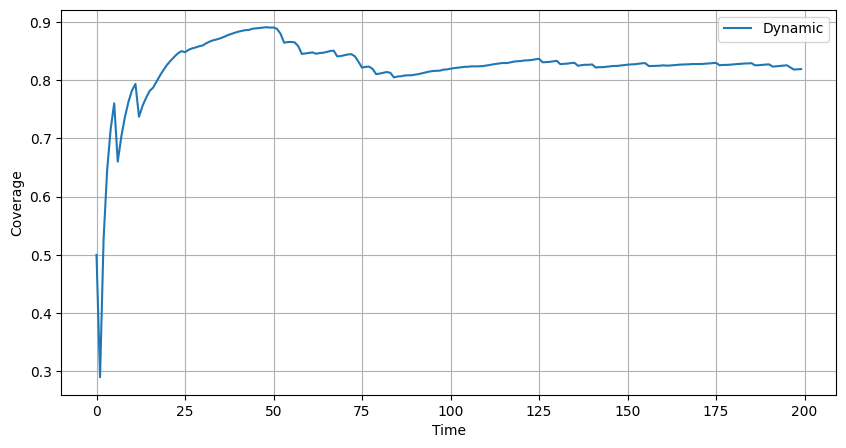

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim import lr_scheduler # import the lr_scheduler module

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.relu = nn.ReLU() # ReLU activation
        self.fc2 = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        # Add an extra dimension to the input data using unsqueeze
        output, _ = self.lstm(x)
        output = self.fc2(output)
        return output

def sigmoid(x):
  """
  Applies the sigmoid function to the input.

  Args:
    x: A number or a NumPy array.

  Returns:
    The sigmoid of the input.
  """
  # Check if x is a PyTorch tensor and detach it if necessary
  if isinstance(x, torch.Tensor):
    x = x.detach().cpu().numpy()  # Detach and move to CPU before converting to NumPy

  return 1 / (1 + np.exp(-x))



def ARC(models, data, target_arc, lam, eta_t, err_t):
    data = data.unsqueeze(0)
    ensemble_probs = torch.zeros(1, 1, num_classes)
    prediction_set_all = []
    temperature = 0.5
    soft_set_temp = 0
    for model in models:
        model.eval()
        output_logits = model(data)
        predicted_probs = F.softmax(output_logits, dim=1)
        ensemble_probs += predicted_probs
    ensemble_probs /= len(models)

    predicted_probs = ensemble_probs

    topk_probs, topk_indices = torch.topk(predicted_probs, num_classes)
    topk_classes = topk_indices.squeeze()

    phis = phi_vec[topk_classes]


    prediction_set = []
    temp = 0
    for prob in predicted_probs.squeeze():
        soft_set_temp += sigmoid(-((prob - lam))/temperature)

        if prob < lam:

            prediction_set.append(phis[temp])
            temp +=1

    soft_set = np.maximum(0, soft_set_temp - 0.5)
    soft_set = torch.tensor(soft_set, requires_grad=True, dtype=torch.float32)

    if len(prediction_set) == 0:
        prediction_set.append(phis[0])

    prediction_set_all.append(prediction_set)

    max_len = max(len(sublist) for sublist in prediction_set_all)
    set_preds_all = [sublist + [sublist[-1]] * (max_len - len(sublist)) for sublist in prediction_set_all]

    # Convert the padded list to a numpy array
    set_preds_all = np.array(set_preds_all)

    set_preds = np.unique(set_preds_all)

    set_size = len(np.unique(set_preds_all))



    return set_size, set_preds, soft_set

trials = 5
all_results_dynamic_08 = []

for tr in range(trials):

    print('Trial', tr)
    prediction_loss_best = 2

    params = np.random.normal(0,1,n_params)

    num_probes = 10
    num_epochs = 200
    num_samples_batch = 1
    num_samples_batch_ent = 1
    learning_rate_q = 0.001
    learning_rate = 0.001

    labels = np.arange(0, 10)
    phi_vec = np.linspace(0, np.pi, labels.size, endpoint=False)
    input_size = num_probes
    output_size = labels.size
    hidden_size = 1000
    intermediate_size = 100
    num_classes = labels.size

    optimizer_q = optim.Adam([torch.tensor(params, requires_grad=True)], lr=learning_rate_q, weight_decay=0.0001)

    error_target = 0.2
    lam = 0.3
    counter_epoch = 0
    coverage = np.zeros(num_epochs)
    set_size_res = np.zeros(num_epochs)
    correct_all = 0


    num_models = 1  # Number of models in the ensemble
    models = []
    for _ in range(num_models):
        model = LSTMModel(input_size, hidden_size, output_size)
        criterion = nn.NLLLoss()  # Use CrossEntropyLoss for multi-class
        models.append(model)

    # Conformal inference parameters
    calibration_set_size = 1
    alpha = 0.1
    err = 0

    random_index = random.choice(range(len(labels)))
    phi_hat = phi_vec[random_index]

    for epoch in range(num_epochs):
        # Create batch data and labels
        data_s = np.zeros((num_samples_batch, input_size))
        target = np.zeros(num_samples_batch, dtype=int)

        for nsb in range(num_samples_batch):
            random_index = random.choice(range(len(labels)))

            data_temp = circuit(params,n_qubits, n_layers, phi = phi_vec[random_index], shots = num_probes)[0]
            bin_data = np.reshape(np.array(data_temp), newshape=(num_probes,n_qubits))

            sample_bin = np.zeros(num_probes)
            for num_p in range(num_probes):
                integer_representation = int("".join(str(int(bit)) for bit in bin_data[num_p, :]), 2)
                sample_bin[num_p] = integer_representation


            data_s[nsb,:] = sample_bin # store the sample in the batch
            target[nsb] = labels[random_index] # store the corresponding label


        # Convert target to one-hot encoding
        target_tensor_one_hot = torch.tensor(target)
        target_tensor = F.one_hot(target_tensor_one_hot, num_classes=num_classes).float()

        # Convert data to PyTorch tensors
        input_tensor = torch.tensor(data_s, dtype=torch.float32)

        for model in models:  # Train each model

            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
            scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.01)
            data = input_tensor  # Pass only the input tensor to the model
            optimizer.zero_grad()

            output = model(data)

            # Calculate loss
            loss = criterion(output.squeeze(0), target_tensor_one_hot.argmax())
            loss.backward()
            optimizer.step()
            scheduler.step()


        loss_cal_sum = 0
        eta_init = 1
        eta_t = eta_init/((epoch+1)**(1./2.)) # Calculate adaptive learning rate for lambda
        for c in range(calibration_set_size):

            random_index = random.choice(range(len(labels)))
            data_temp = circuit(params,n_qubits, n_layers, phi = phi_vec[random_index], shots = num_probes)[0]
            bin_data = np.reshape(np.array(data_temp), newshape=(num_probes,n_qubits))

            sample_bin = np.zeros(num_probes)
            for num_p in range(num_probes):
                integer_representation = int("".join(str(int(bit)) for bit in bin_data[num_p, :]), 2)
                sample_bin[num_p] = integer_representation

            s = sample_bin

            set_size, set_preds, set_soft = ARC(models, torch.tensor(s, dtype=torch.float32), random_index, lam, eta_t, err)

            #mis-coverage loss
            if phi_vec[random_index] in set_preds:
                loss_cal_sum += 0
            else:
                loss_cal_sum += 1

            #bias loss
            #loss_cal = 0
            #for pred in set_preds:
            #    loss_cal_sum += np.abs(pred - phi_vec[random_index])

            #loss_cal /= set_size


        #eta_t = 0.1
        lam = lam + (eta_t) * (loss_cal_sum/calibration_set_size - error_target)

        for j in range(num_samples_batch_ent):


            random_index = random.choice(range(len(labels)))
            data_temp = circuit(params, n_qubits, n_layers, phi=phi_vec[random_index], shots=num_probes)[0]

            # Convert the output to a NumPy array
            data_temp_np = data_temp.detach().numpy()

            # Reshape the data
            bin_data = data_temp_np.reshape(num_probes, n_qubits)

            # Convert binary data to integers
            sample_bin = np.zeros(num_probes)
            for num_p in range(num_probes):
                integer_representation = int("".join(str(int(bit)) for bit in bin_data[num_p, :]), 2)
                sample_bin[num_p] = integer_representation

            s = sample_bin

            input_tensor = torch.tensor(s, dtype=torch.float32)

            set_size, set_preds, set_soft = ARC(models, input_tensor, random_index, lam, eta_t, err)

            optimizer_q.zero_grad()

            # Compute the soft loss
            loss_q = set_soft

            # Compute the log-probability gradient
            loss_q.backward()

            # Perform a gradient update
            optimizer_q.step()


        if epoch%1 == 0:

            correct_clas =  0
            num_test = 50
            Loss_set = 0
            set_size_sum_sum = 0
            set_size_sum_soft = 0
            correct = 0
            Loss_pred = 0
            for num_t in range(num_test):
                random_index = random.choice(range(len(labels)))

                data_temp = circuit(params,n_qubits, n_layers, phi = phi_vec[random_index], shots = num_probes)[0]
                bin_data = np.reshape(np.array(data_temp), newshape=(num_probes,n_qubits))

                sample_bin = np.zeros(num_probes)
                for num_p in range(num_probes):
                    integer_representation = int("".join(str(int(bit)) for bit in bin_data[num_p, :]), 2)
                    sample_bin[num_p] = integer_representation

                s = sample_bin
                test_input = torch.tensor(s, dtype=torch.float32)

                set_size, set_preds, set_soft = ARC(models, test_input, random_index, lam, eta_t, err)
                set_size_sum_sum += set_size
                set_size_sum_soft += set_soft

                Loss_temp_min = 10
                for element in set_preds:
                    Loss_temp = np.abs(element - phi_vec[random_index])
                    if Loss_temp < Loss_temp_min:
                        Loss_temp_min = Loss_temp

                Loss_set += Loss_temp_min

                if phi_vec[random_index] in set_preds:
                    correct += 1

            correct_all += (correct/num_test)
            coverage[epoch] = correct_all/(epoch+1)
            set_size_res[epoch] = set_size_sum_soft.detach().numpy()/num_test

            print("Epoch:", epoch, "NLL loss:", loss.item(), "Coverage", correct_all/(epoch+1), "Set loss", Loss_set/(num_test), "Set size", set_size_sum_soft/num_test)

            if Loss_pred/(num_test) < prediction_loss_best:
                prediction_loss_best = Loss_pred/(num_test)
                best_params = params.copy()



    print( "Prediction loss (best):", prediction_loss_best)

    results = {
        'trial': tr,
        'coverage': coverage,
        'set_size': set_size_res,
    }
    all_results_dynamic_08.append(results)

    fig1 = plt.figure(figsize=(10,5))
    plt.plot(coverage, label='Dynamic')
    plt.xlabel("Time")
    plt.ylabel("Coverage")
    plt.legend()
    plt.grid()
    plt.show(fig1)

with open('/content/drive/MyDrive/Colab Notebooks/results/all_results_dynamic_08.pkl', 'wb') as f:
    pickle.dump(all_results_dynamic_08, f)
